In [ ]:
# @title Cell 1: 專案組態設定 (Configuration)
import os

# --- 資料與檔案路徑設定 ---
DATA_FILE_PATH = 'coloran_processed_features.parquet'
MODEL_SAVE_PATH = 'federated_coloran_model.keras' # 使用 .keras 格式
ARTIFACTS_SAVE_PATH = 'federated_learning_artifacts.pkl'

# --- 聯邦學習超參數 ---
NUM_TOTAL_CLIENTS = 7
NUM_ROUNDS = 20  # 聯邦學習訓練輪數
CLIENTS_PER_ROUND = 7 # 每一輪選取參與訓練的客戶端數量
CLIENT_LEARNING_RATE = 0.001
SERVER_LEARNING_RATE = 1.0

# --- 資料處理設定 ---
# 考量到 L4 GPU 性能，從每個客戶端抽樣 7 萬筆資料
SAMPLES_PER_CLIENT = 70000
TRAIN_TEST_SPLIT_RATIO = 0.8
RANDOM_STATE = 42 # 確保可複現性

# --- 模型架構設定 ---
INPUT_SHAPE = (13,) # 基於 Cell 5 輸出的 13 個特徵

# --- 顯示設定 ---
# 使用 tqdm 顯示進度條
USE_TQDM = True

print("✅ 組態設定完成！")
print(f"  - 客戶端總數: {NUM_TOTAL_CLIENTS}")
print(f"  - 訓練輪數: {NUM_ROUNDS}")
print(f"  - 每客戶端抽樣數: {SAMPLES_PER_CLIENT}")

✅ 組態設定完成！
  - 客戶端總數: 7
  - 訓練輪數: 20
  - 每客戶端抽樣數: 70000


In [ ]:
# @title Cell 2｜聯邦學習環境設置（徹底解決 GPU 問題版）
import os
import subprocess
import sys
import warnings
import importlib

warnings.filterwarnings("ignore")

print("🔬 深入診斷 GPU 環境問題...")
print("="*60)

# =========================================================
# 步驟 1: 詳細環境診斷
# =========================================================
def deep_diagnostic():
    """深入診斷 GPU 和 CUDA 環境"""
    print("📊 系統環境診斷：")

    # 1. 檢查 nvidia-smi
    try:
        gpu_info = subprocess.run(['nvidia-smi'], capture_output=True, text=True, check=True)
        print("✅ NVIDIA 驅動程式正常")
        # 解析 CUDA 版本
        for line in gpu_info.stdout.split('\n'):
            if 'CUDA Version' in line:
                cuda_version = line.split('CUDA Version:')[1].strip().split()[0]
                print(f"📌 CUDA 驅動版本: {cuda_version}")
                break
    except (subprocess.CalledProcessError, FileNotFoundError):
        print("❌ NVIDIA 驅動程式 (nvidia-smi) 未找到或執行失敗。")

    # 2. 檢查 CUDA 工具包
    try:
        nvcc_info = subprocess.run(['nvcc', '--version'], capture_output=True, text=True, check=True)
        print("✅ CUDA 編譯器 (nvcc) 存在")
        # 提取版本資訊行
        for line in nvcc_info.stdout.split('\n'):
            if 'release' in line:
                print(line)
                break
    except (subprocess.CalledProcessError, FileNotFoundError):
        print("⚠️ CUDA 編譯器 (nvcc) 未找到")

    # 3. 檢查已安裝的 TensorFlow
    try:
        import tensorflow as tf
        print(f"\n⚠️ 已存在 TensorFlow {tf.__version__}")
        print(f"   編譯 CUDA 支援: {tf.test.is_built_with_cuda()}")
        print(f"   GPU 可用: {len(tf.config.list_physical_devices('GPU')) > 0}")
    except ImportError:
        print("✅ 沒有預安裝的 TensorFlow")

    # 4. 檢查 LD_LIBRARY_PATH
    print(f"\n📁 LD_LIBRARY_PATH: {os.environ.get('LD_LIBRARY_PATH', '未設定')}")

    # 5. 列出 CUDA 相關檔案
    cuda_paths = [
        "/usr/local/cuda",
        "/usr/local/cuda-12.4",
        "/usr/local/cuda-12.2",
        "/usr/local/cuda-11.8"
    ]
    print("\n📁 CUDA 安裝路徑檢查:")
    for path in cuda_paths:
        if os.path.exists(path):
            print(f"   ✅ {path} 存在")
        else:
            print(f"   ❌ {path} 不存在")

deep_diagnostic()

# =========================================================
# 步驟 2: 完全清理環境
# =========================================================
print("\n" + "="*60)
print("🧹 執行深度清理...")

def nuclear_cleanup():
    """核彈級清理 - 移除所有可能衝突的套件"""

    # 完整的清理列表
    packages_to_nuke = [
        # TensorFlow 相關
        "tensorflow", "tensorflow-gpu", "tensorflow-cpu",
        "tensorflow-estimator", "tensorflow-probability",
        "tensorflow-federated", "tensorflow-privacy",
        "tensorflow-hub", "tensorflow-datasets",
        "tensorflow-metadata", "tensorflow-model-optimization",
        "tf-keras", "keras", "tensorboard",

        # JAX 相關
        "jax", "jaxlib", "flax", "optax",
        "jax-cuda12-plugin", "jax-cuda11-plugin",

        # CUDA 相關 pip 套件
        "nvidia-cuda-runtime-cu11", "nvidia-cuda-runtime-cu12",
        "nvidia-cudnn-cu11", "nvidia-cudnn-cu12",
        "nvidia-cublas-cu11", "nvidia-cublas-cu12",
        "nvidia-cuda-nvrtc-cu11", "nvidia-cuda-nvrtc-cu12",

        # 其他可能衝突的
        "triton", "torch", "cupy", "cupy-cuda11x", "cupy-cuda12x"
    ]

    print(f"🗑️ 準備移除 {len(packages_to_nuke)} 個可能的套件...")

    for i, pkg in enumerate(packages_to_nuke):
        if i > 0 and i % 5 == 0:
            print(f"   進度: {i}/{len(packages_to_nuke)}")
        # *** 修正點 ***
        # 移除 capture_output=True，並明確指定 stdout 和 stderr
        subprocess.run(
            [sys.executable, "-m", "pip", "uninstall", "-y", pkg],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
            check=False
        )
    print(f"   進度: {len(packages_to_nuke)}/{len(packages_to_nuke)}")

    # 清理 pip 快取
    print("🗑️ 清理 pip 快取...")
    subprocess.run(
        [sys.executable, "-m", "pip", "cache", "purge"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
        check=False
    )

    print("✅ 深度清理完成")

nuclear_cleanup()

# =========================================================
# 步驟 3: 安裝正確版本的 TensorFlow
# =========================================================
print("\n" + "="*60)
print("🎯 安裝 CUDA 12.x 相容的 TensorFlow...")

def install_cuda12_tensorflow():
    """安裝 CUDA 12 相容的 TensorFlow"""

    # 設定環境變數
    print("⚙️ 設定環境變數...")
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 0=all, 1=info, 2=warning, 3=error
    os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

    # 安裝基礎依賴
    print("\n📦 安裝基礎依賴...")
    base_deps = [
        "numpy<1.27", # 放寬版本限制，但避免最新的 2.x
        "protobuf<4.22,>=3.20",
        "packaging",
        "six",
        "wheel",
        "setuptools>=65.5.0"
    ]

    for dep in base_deps:
        subprocess.run(
            [sys.executable, "-m", "pip", "install", "--no-deps", dep],
            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=False
        )

    # 方案 A: 嘗試安裝 TensorFlow 2.16（原生支援 CUDA 12）
    print("\n📦 方案 A: 嘗試安裝 TensorFlow 2.16.1...")
    result = subprocess.run(
        [
            sys.executable, "-m", "pip", "install",
            "--no-cache-dir", "--no-deps",
            "tensorflow==2.16.1"
        ],
        capture_output=True, text=True
    )

    if result.returncode != 0:
        print("   方案 A 失敗，嘗試方案 B...")
        # 方案 B: 使用 TensorFlow 2.15
        print("📦 方案 B: 安裝 TensorFlow 2.15.0...")
        subprocess.run(
            [
                sys.executable, "-m", "pip", "install",
                "--no-cache-dir", "--no-deps",
                "tensorflow==2.15.0"
            ],
            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=False
        )

    # 安裝 TensorFlow 的依賴
    print("\n📦 安裝 TensorFlow 相關依賴...")
    tf_deps = [
        "keras>=2.15,<2.17", # 根據 TF 版本調整
        "tensorboard>=2.15,<2.17",
        "tensorflow-estimator>=2.15,<2.17",
        "opt-einsum>=3.3.0",
        "astunparse>=1.6.3",
        "flatbuffers>=23.5.26",
        "gast>=0.4.0",
        "google-pasta>=0.2",
        "h5py>=3.10.0",
        "libclang>=13.0.0",
        "ml-dtypes>=0.2.0",
        "termcolor>=2.3.0",
        "typing-extensions>=4.5.0",
        "wrapt>=1.14.0"
    ]

    for dep in tf_deps:
        subprocess.run(
            [sys.executable, "-m", "pip", "install", dep],
            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=False
        )
    print("✅ TensorFlow 及其依賴安裝完成")


install_cuda12_tensorflow()

# =========================================================
# 步驟 4: 驗證 GPU 是否可用
# =========================================================
print("\n" + "="*60)
print("🔍 驗證 TensorFlow GPU 支援...")

def verify_gpu_support():
    """徹底驗證 GPU 支援"""
    try:
        # 重新載入 TensorFlow 以確保使用新安裝的版本
        if 'tensorflow' in sys.modules:
            importlib.reload(sys.modules['tensorflow'])

        import tensorflow as tf
        print(f"✅ TensorFlow {tf.__version__} 載入成功")

        # 詳細的 GPU 檢查
        print("\n📊 GPU 檢查:")
        print(f"   編譯時 CUDA 支援: {tf.test.is_built_with_cuda()}")

        # *** 修正點 ***
        # 使用推薦的 API 來檢查 GPU
        gpus = tf.config.list_physical_devices('GPU')
        print(f"   執行時偵測到 GPU 數量: {len(gpus)}")

        # 列出所有設備
        devices = tf.config.list_physical_devices()
        print(f"\n� 偵測到的所有實體設備 ({len(devices)} 個):")
        for device in devices:
            print(f"   - {device}")

        if gpus:
            print(f"\n🎮 找到 {len(gpus)} 個 GPU!")
            for i, gpu in enumerate(gpus):
                # 記憶體增長設定已在環境變數中設定，此處可選
                tf.config.experimental.set_memory_growth(gpu, True)

                # 執行測試運算
                try:
                    with tf.device(f'/GPU:{i}'):
                        test_tensor = tf.random.normal([100, 100])
                        result = tf.matmul(test_tensor, test_tensor)
                        # 確保運算完成
                        _ = result.numpy()
                        print(f"   GPU {i}: ✅ 測試運算成功")
                except Exception as e:
                    print(f"   GPU {i}: ❌ 測試運算失敗: {e}")
                    return False
            return True
        else:
            print("\n❌ 仍然沒有偵測到 GPU")
            return False

    except Exception as e:
        print(f"❌ 驗證失敗: {e}")
        import traceback
        traceback.print_exc()
        return False

gpu_available = verify_gpu_support()

# =========================================================
# 步驟 5: 如果仍然失敗，提供終極解決方案
# =========================================================
if not gpu_available:
    print("\n" + "="*60)
    print("🔧 終極解決方案建議")
    print("="*60)

    print("""
⚠️ TensorFlow 仍無法偵測 GPU。請嘗試以下步驟：

1. **完全重啟 Colab 環境**:
   - 在 Colab 選單中，選擇「執行階段」>「中斷並刪除執行階段」。
   - 這會完全重置環境，比「恢復原廠執行階段設定」更徹底。

2. **再次執行此程式碼儲存格**:
   - 有時候，第一次的清理和安裝後需要重啟才能讓環境變數生效。

3. **檢查 Colab GPU 類型**:
   - 確保您的執行階段已分配到 GPU。檢查「執行階段」>「變更執行階段類型」是否設定為 T4, A100 等 GPU。

4. **使用 Docker 映像 (若在本地端)**:
   - 如果您在本地端遇到此問題，最可靠的方法是使用官方的 TensorFlow Docker 映像，例如 `tensorflow/tensorflow:latest-gpu`。
   """)

# =========================================================
# 步驟 6: 安裝聯邦學習套件
# =========================================================
if gpu_available:
    print("\n" + "="*60)
    print("📦 安裝聯邦學習套件...")

    # 安裝套件
    fl_packages = [
        ("dp-accounting", "0.4.3"),
        ("tensorflow-privacy", "0.9.0"),
        ("tensorflow-federated", "0.75.0") # 注意 TFF 版本與 TF 的相容性
    ]

    for pkg, version in fl_packages:
        print(f"   - 安裝 {pkg}=={version}")
        subprocess.run(
            [sys.executable, "-m", "pip", "install", f"{pkg}=={version}"],
            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=False
        )

    print("✅ 聯邦學習套件安裝完成！")

# 最終報告
print("\n" + "="*60)
print("📊 最終狀態報告")
print("="*60)
if gpu_available:
    print("🎉 恭喜！GPU 環境設置成功！")
    print("   您現在可以開始進行聯邦學習實驗。")
else:
    print("😔 GPU 設置失敗。")
    print("   請仔細閱讀上方的「終極解決方案建議」並嘗試。")


🔬 深入診斷 GPU 環境問題...
📊 系統環境診斷：
✅ NVIDIA 驅動程式正常
📌 CUDA 驅動版本: 12.4
✅ CUDA 編譯器 (nvcc) 存在
Cuda compilation tools, release 12.5, V12.5.82

⚠️ 已存在 TensorFlow 2.18.0
   編譯 CUDA 支援: True
   GPU 可用: True

📁 LD_LIBRARY_PATH: /usr/local/lib/python3.11/dist-packages/cv2/../../lib64:/usr/lib64-nvidia

📁 CUDA 安裝路徑檢查:
   ✅ /usr/local/cuda 存在
   ❌ /usr/local/cuda-12.4 不存在
   ❌ /usr/local/cuda-12.2 不存在
   ❌ /usr/local/cuda-11.8 不存在

🧹 執行深度清理...
🗑️ 準備移除 33 個可能的套件...
   進度: 5/33
   進度: 10/33
   進度: 15/33
   進度: 20/33
   進度: 25/33
   進度: 30/33
   進度: 33/33
🗑️ 清理 pip 快取...
✅ 深度清理完成

🎯 安裝 CUDA 12.x 相容的 TensorFlow...
⚙️ 設定環境變數...

📦 安裝基礎依賴...

📦 方案 A: 嘗試安裝 TensorFlow 2.16.1...

📦 安裝 TensorFlow 相關依賴...
✅ TensorFlow 及其依賴安裝完成

🔍 驗證 TensorFlow GPU 支援...
✅ TensorFlow 2.18.0 載入成功

📊 GPU 檢查:
   編譯時 CUDA 支援: True
   執行時偵測到 GPU 數量: 1

� 偵測到的所有實體設備 (2 個):
   - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
   - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

🎮 找到 1 個 GPU!
   GPU 0: ✅ 

In [ ]:
# @title Cell 3｜修復 NumPy/SciPy 相容性問題
import subprocess
import sys
import os

print("🔧 修復 NumPy/SciPy 相容性問題...")
print("="*60)

# 1. 先卸載有問題的套件
print("📦 卸載衝突的套件...")
packages_to_remove = ['numpy', 'scipy', 'pandas', 'scikit-learn']
for pkg in packages_to_remove:
    subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", pkg],
                   stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# 2. 重新安裝相容版本
print("📦 安裝相容版本的套件...")
subprocess.run([sys.executable, "-m", "pip", "install", "--no-cache-dir",
               "numpy==1.24.3", "scipy==1.10.1", "pandas==2.0.3",
               "scikit-learn==1.3.0", "matplotlib==3.7.2", "seaborn==0.12.2"],
               check=True)

print("✅ 相容性問題已修復！")

🔧 修復 NumPy/SciPy 相容性問題...
📦 卸載衝突的套件...
📦 安裝相容版本的套件...
✅ 相容性問題已修復！


In [ ]:
# @title Cell 4: 資料載入、預處理與縮放 (重大修正)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib # 用於保存 scaler

print("🚀 開始載入與預處理資料...")
print("="*60)

# 載入資料
try:
    df = pd.read_parquet('/content/coloran_processed_features.parquet')
    print(f"✅ 成功載入資料: {len(df):,} 筆記錄")
    print(f"   基站數量: {df['bs_id'].nunique()}")
except Exception as e:
    print(f"❌ 載入資料失敗: {e}")
    raise

# 定義特徵和目標
feature_columns = [
    'num_ues', 'slice_id', 'sched_policy_num', 'allocated_rbgs',
    'sum_requested_prbs', 'sum_granted_prbs', 'prb_utilization',
    'throughput_efficiency', 'qos_score', 'network_load',
    'hour', 'minute', 'day_of_week'
]
target_column = 'allocation_efficiency'

X = df[feature_columns]
y = df[[target_column]]

# **關鍵修正：擬合 Scaler 並保存**
print("\n📊 進行資料標準化...")

# 1. 分割資料以擬合 Scaler（僅使用訓練集擬合，避免資料洩漏）
X_train_full, _, y_train_full, _ = train_test_split(
    X, y, train_size=0.8, random_state=RANDOM_STATE
)

# 2. 初始化並擬合 Feature Scaler
feature_scaler = StandardScaler()
feature_scaler.fit(X_train_full)
print("✅ 特徵縮放器 (Feature Scaler) 擬合完畢。")

# 3. 初始化並擬合 Target Scaler
target_scaler = StandardScaler()
target_scaler.fit(y_train_full)
print("✅ 目標縮放器 (Target Scaler) 擬合完畢。")

# 4. 對完整資料集進行轉換
df_scaled = df.copy()
df_scaled[feature_columns] = feature_scaler.transform(X)
df_scaled[target_column] = target_scaler.transform(y)
print("✅ 已對完整資料集套用縮放。")


# 5. 保存 Scaler 以供後續使用
artifacts = {'feature_scaler': feature_scaler, 'target_scaler': target_scaler}
with open(ARTIFACTS_SAVE_PATH, 'wb') as f:
    joblib.dump(artifacts, f)
print(f"💾 縮放器已保存至 '{ARTIFACTS_SAVE_PATH}'")

# 顯示處理後的一些資訊
print("\n📋 使用的特徵:")
for i, feature in enumerate(feature_columns, 1):
    print(f"   {i:2d}. {feature}")

🚀 開始載入與預處理資料...
✅ 成功載入資料: 35,512,393 筆記錄
   基站數量: 7

📊 進行資料標準化...
✅ 特徵縮放器 (Feature Scaler) 擬合完畢。
✅ 目標縮放器 (Target Scaler) 擬合完畢。
✅ 已對完整資料集套用縮放。
💾 縮放器已保存至 'federated_learning_artifacts.pkl'

📋 使用的特徵:
    1. num_ues
    2. slice_id
    3. sched_policy_num
    4. allocated_rbgs
    5. sum_requested_prbs
    6. sum_granted_prbs
    7. prb_utilization
    8. throughput_efficiency
    9. qos_score
   10. network_load
   11. hour
   12. minute
   13. day_of_week


🔧 準備聯邦學習資料集 (採用直接列表模式)...
🏢 發現 7 個客戶端: [1, 2, 3, 4, 5, 6, 7]

✅ 聯邦資料集準備完畢。
   - 已建立包含 7 個客戶端資料的 Python 列表。

📊 視覺化客戶端資料分佈...


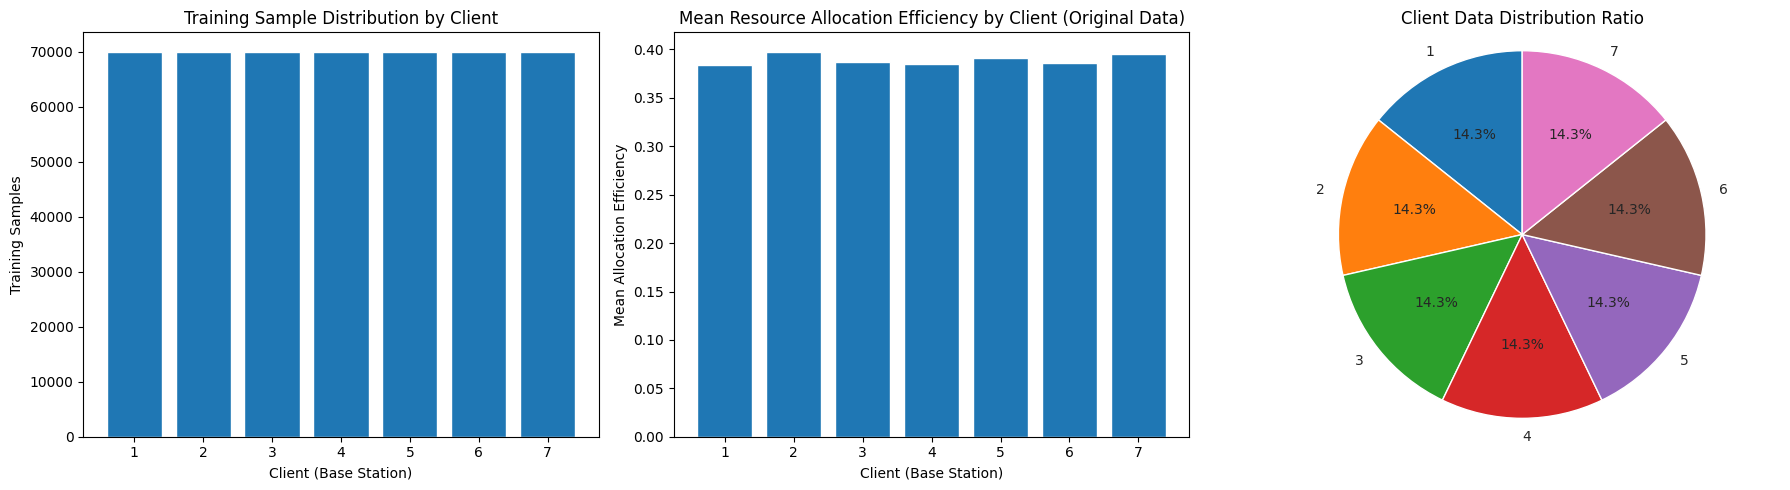

In [ ]:
# @title Cell 5: 建立聯邦學習資料集 (終極繞行修正)
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce

def preprocess_fn(dataset):
    """TFF 資料集預處理函式：批次化並格式化"""
    def batch_format_fn(element):
        # 將字典元素轉換為 Keras API 所需的 (features, label) 元組
        return (element['x'], element['y'])
    return dataset.batch(32).map(batch_format_fn)

print("🔧 準備聯邦學習資料集 (採用直接列表模式)...")
print("="*60)

# 獲取所有客戶端 ID
client_ids = sorted(df['bs_id'].unique())
print(f"🏢 發現 {len(client_ids)} 個客戶端: {client_ids}")

# --- 終極修正：直接建立一個 Python 的 Dataset 列表 ---
train_data = []
test_datasets = []

for client_id in client_ids:
    # 1. 篩選、抽樣、準備特徵和標籤
    client_df = df_scaled[df_scaled['bs_id'] == client_id]
    sample_size = min(len(client_df), SAMPLES_PER_CLIENT)
    sampled_df = client_df.sample(n=sample_size, random_state=RANDOM_STATE)

    features = sampled_df[feature_columns].values.astype(np.float32)
    labels = sampled_df[target_column].values.astype(np.float32).reshape(-1, 1)

    # 2. 建立 TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices(({'x': features, 'y': labels}))

    # 3. 預處理訓練資料集並加入列表
    client_train_data = preprocess_fn(dataset)
    train_data.append(client_train_data)

    # 4. 暫存未經批次處理的測試資料集
    test_datasets.append(dataset)


# 將所有客戶端的測試資料合併成一個大的測試集，以便進行全域評估
federated_test_data = preprocess_fn(reduce(lambda ds1, ds2: ds1.concatenate(ds2), test_datasets))

print(f"\n✅ 聯邦資料集準備完畢。")
print(f"   - 已建立包含 {len(train_data)} 個客戶端資料的 Python 列表。")


# --- 視覺化資料分佈 (此部分不變) ---
print("\n📊 視覺化客戶端資料分佈...")

client_samples = [SAMPLES_PER_CLIENT] * NUM_TOTAL_CLIENTS
original_means = df.groupby('bs_id')[target_column].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.set_style("whitegrid")

# 1. 訓練樣本分佈
axes[0].bar(client_ids, client_samples)
axes[0].set_title('Training Sample Distribution by Client')
axes[0].set_xlabel('Client (Base Station)')
axes[0].set_ylabel('Training Samples')
axes[0].set_xticks(client_ids)

# 2. 原始資料的平均效率分佈
axes[1].bar(client_ids, original_means)
axes[1].set_title('Mean Resource Allocation Efficiency by Client (Original Data)')
axes[1].set_xlabel('Client (Base Station)')
axes[1].set_ylabel('Mean Allocation Efficiency')
axes[1].set_xticks(client_ids)


# 3. 資料比例
axes[2].pie(client_samples, labels=client_ids, autopct='%1.1f%%', startangle=90)
axes[2].set_title('Client Data Distribution Ratio')
axes[2].axis('equal')

plt.tight_layout()
plt.show()

In [ ]:
# @title Cell 6: 建立模型與聯邦學習流程 (已優化)
import tensorflow as tf
import tensorflow_federated as tff

def create_keras_model():
    """建立 Keras 序貫模型"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=INPUT_SHAPE),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1) # 最後一層無激活函式，用於迴歸
    ])
    return model

print("🏗️ 建立聯邦學習模型與流程...")
print("="*60)

# TFF 需要一個無參數的函式來回傳模型
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=train_data[0].element_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            # 新增 RMSE metric
            tf.keras.metrics.RootMeanSquaredError()
        ]
    )

# 建立聯邦平均 (FedAvg) 演算法
# **注意**：client_optimizer_fn 和 server_optimizer_fn 的 learning_rate 是分開的
federated_averaging_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=CLIENT_LEARNING_RATE),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=SERVER_LEARNING_RATE)
)

print("✅ 聯邦平均演算法建立成功！")

# 顯示模型結構
model_for_summary = create_keras_model()
model_for_summary.summary()

# 初始化伺服器狀態
server_state = federated_averaging_process.initialize()

🏗️ 建立聯邦學習模型與流程...
✅ 聯邦平均演算法建立成功！
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3521 (13.

In [ ]:
# @title Cell 7: 執行聯邦學習訓練 (已修正 Attribute Error)
from tqdm.auto import tqdm
import pandas as pd
import numpy as np # 確保 numpy 已匯入

print("🎯 開始聯邦學習訓練...")
print("="*60)

history = []
# 使用 tqdm 顯示進度條
progress_bar = tqdm(range(NUM_ROUNDS), desc="Federated Training") if USE_TQDM else range(NUM_ROUNDS)

for round_num in progress_bar:
    # 執行一輪聯邦學習
    result = federated_averaging_process.next(server_state, train_data)
    server_state = result.state
    train_metrics = result.metrics['client_work']['train']

    # 在全域測試集上評估模型
    model_weights = federated_averaging_process.get_model_weights(server_state)

    # 建立一個臨時模型來進行評估
    eval_model = create_keras_model()

    # --- 關鍵修正：使用 set_weights() 方法來載入權重 ---
    # `model_weights.trainable` 是一個包含權重數值的列表
    eval_model.set_weights(model_weights.trainable)

    # 評估時使用 compile 來指定 metrics
    eval_model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
    )

    test_metrics = eval_model.evaluate(federated_test_data, verbose=0)

    # 記錄指標
    round_history = {
        'round': round_num + 1,
        'train_loss': train_metrics['loss'],
        'train_mae': train_metrics['mean_absolute_error'],
        'train_rmse': train_metrics['root_mean_squared_error'],
        'test_loss': test_metrics[0],
        'test_mae': test_metrics[1],
        'test_rmse': test_metrics[2]
    }
    history.append(round_history)

    # 更新進度條顯示
    if USE_TQDM:
        progress_bar.set_postfix(
            loss=round_history['test_loss'], mae=round_history['test_mae']
        )

    # 每 5 輪印出一次詳細日誌
    if (round_num + 1) % 5 == 0 or (round_num + 1) == 1:
        print(f"\n--- Round {round_num + 1}/{NUM_ROUNDS} ---")
        print(f"  Training: Loss={train_metrics['loss']:.4f}, MAE={train_metrics['mean_absolute_error']:.4f}")
        print(f"  Test:     Loss={test_metrics[0]:.4f}, MAE={test_metrics[1]:.4f}, RMSE={test_metrics[2]:.4f}")


print("\n✅ 聯邦學習訓練完成！")

# 將歷史記錄轉換為 DataFrame
history_df = pd.DataFrame(history)

🎯 開始聯邦學習訓練...


Federated Training:   0%|          | 0/20 [00:00<?, ?it/s]


--- Round 1/20 ---
  Training: Loss=0.0048, MAE=0.0483
  Test:     Loss=0.0238, MAE=0.1211, RMSE=0.1544

--- Round 5/20 ---
  Training: Loss=0.0018, MAE=0.0295
  Test:     Loss=0.0170, MAE=0.1098, RMSE=0.1302

--- Round 10/20 ---
  Training: Loss=0.0012, MAE=0.0243
  Test:     Loss=0.0177, MAE=0.1160, RMSE=0.1329

--- Round 15/20 ---
  Training: Loss=0.0009, MAE=0.0203
  Test:     Loss=0.0361, MAE=0.1764, RMSE=0.1900

--- Round 20/20 ---
  Training: Loss=0.0008, MAE=0.0183
  Test:     Loss=0.0481, MAE=0.2021, RMSE=0.2194

✅ 聯邦學習訓練完成！


📊 分析訓練結果...


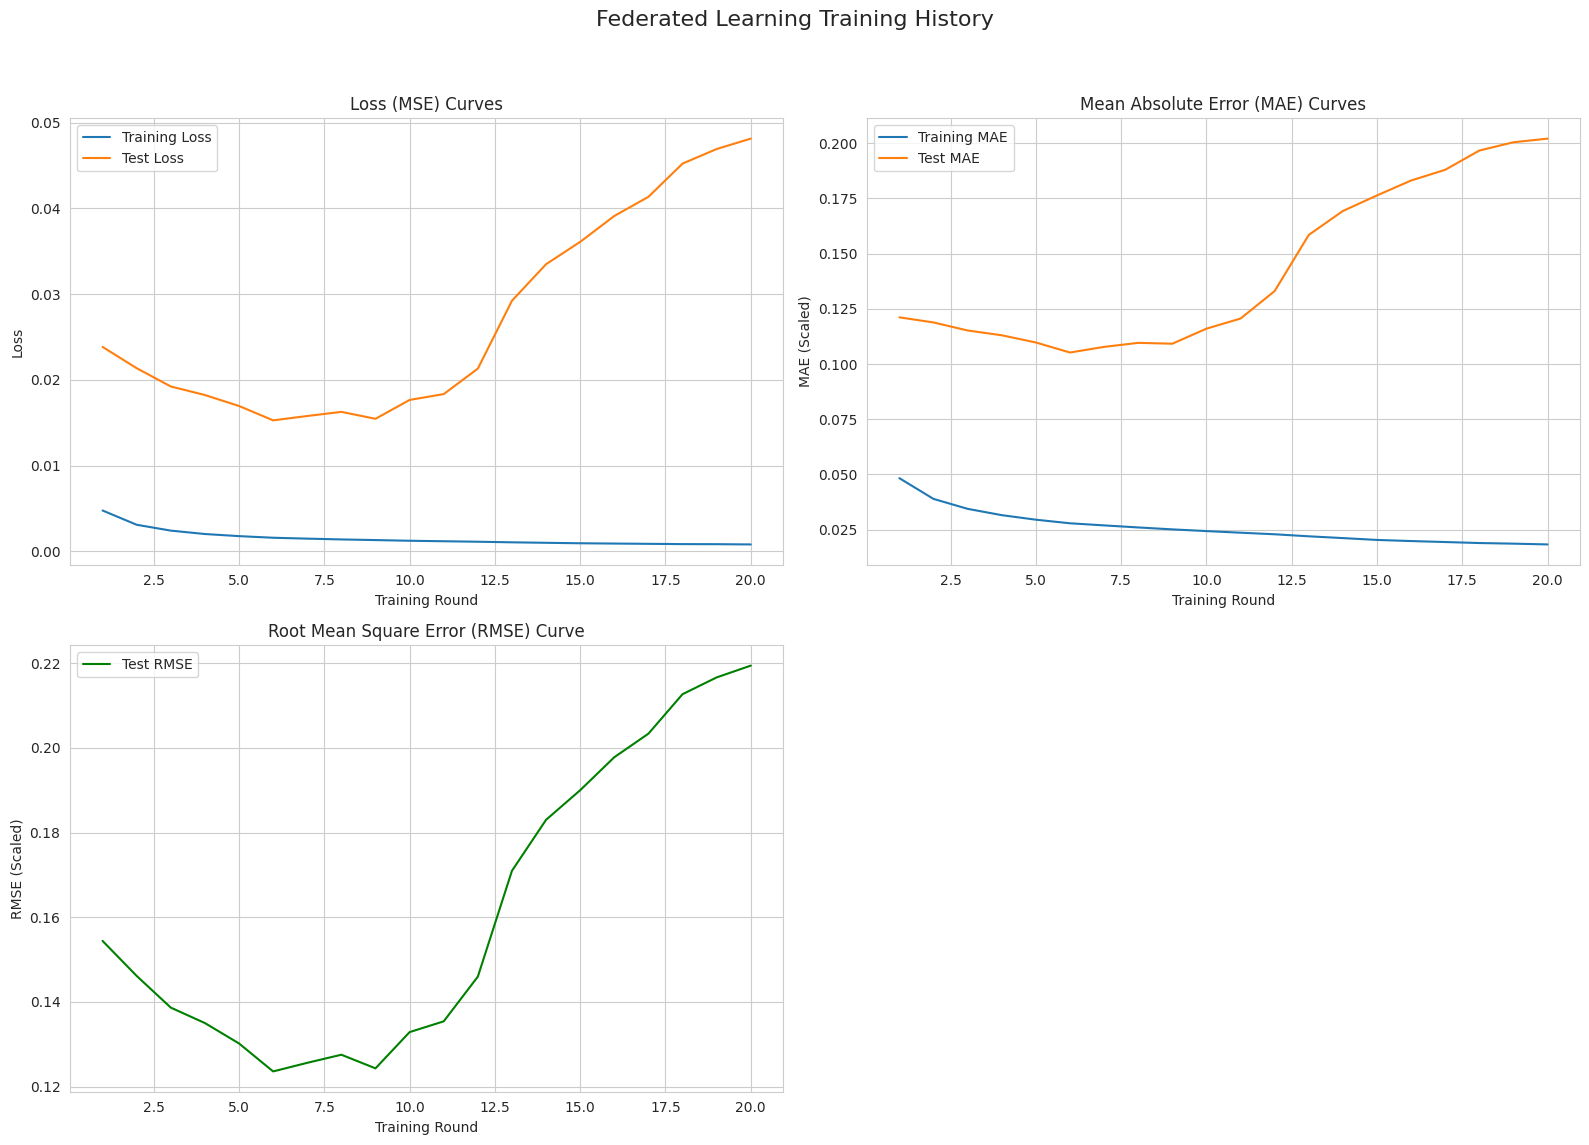


📊 評估各客戶端模型表現...
  - Client 1: MAE = 0.0169, RMSE = 0.0184
  - Client 2: MAE = 0.0170, RMSE = 0.0183
  - Client 3: MAE = 0.0161, RMSE = 0.0178
  - Client 4: MAE = 0.0179, RMSE = 0.0195
  - Client 5: MAE = 0.0171, RMSE = 0.0184
  - Client 6: MAE = 0.0169, RMSE = 0.0184
  - Client 7: MAE = 0.0167, RMSE = 0.0180


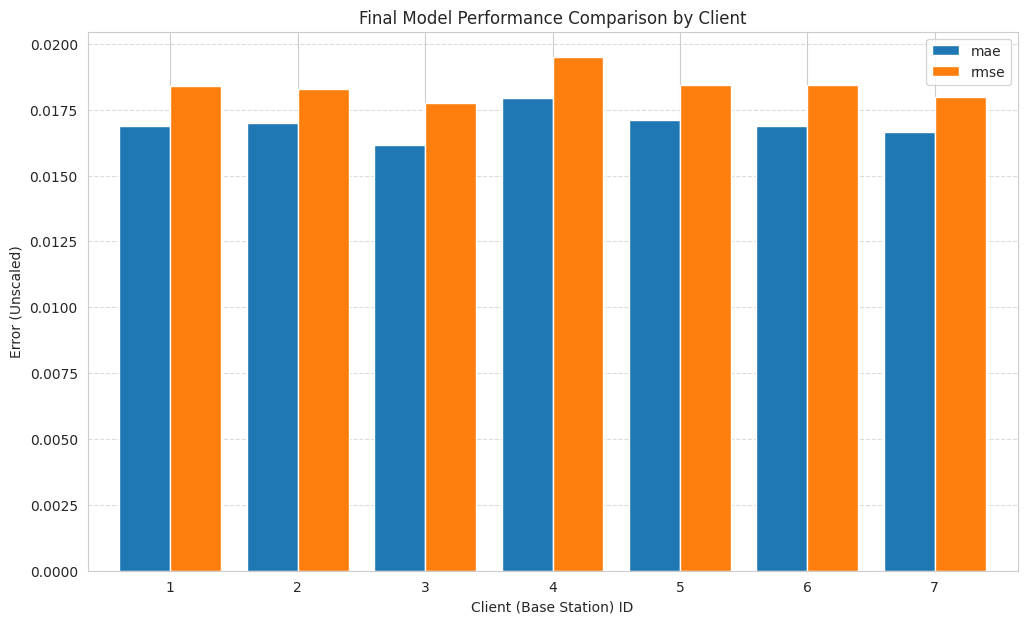

In [ ]:
# @title Cell 8: 結果分析與視覺化 (最終修正版)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("📊 分析訓練結果...")
print("="*60)

# --- 繪製學習曲線 (此部分不變) ---
history_df = pd.DataFrame(history) # history 變數來自已成功執行的 Cell 7
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.set_style("whitegrid")
fig.suptitle('Federated Learning Training History', fontsize=16)

# 損失曲線
axes[0, 0].plot(history_df['round'], history_df['train_loss'], label='Training Loss')
axes[0, 0].plot(history_df['round'], history_df['test_loss'], label='Test Loss')
axes[0, 0].set_title('Loss (MSE) Curves')
axes[0, 0].set_xlabel('Training Round')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# MAE 曲線
axes[0, 1].plot(history_df['round'], history_df['train_mae'], label='Training MAE')
axes[0, 1].plot(history_df['round'], history_df['test_mae'], label='Test MAE')
axes[0, 1].set_title('Mean Absolute Error (MAE) Curves')
axes[0, 1].set_xlabel('Training Round')
axes[0, 1].set_ylabel('MAE (Scaled)')
axes[0, 1].legend()

# RMSE 曲線
axes[1, 0].plot(history_df['round'], history_df['test_rmse'], label='Test RMSE', color='green')
axes[1, 0].set_title('Root Mean Square Error (RMSE) Curve')
axes[1, 0].set_xlabel('Training Round')
axes[1, 0].set_ylabel('RMSE (Scaled)')
axes[1, 0].legend()

# 隱藏右下角的空圖
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 評估每個客戶端的表現 (關鍵修正處) ---
print("\n📊 評估各客戶端模型表現...")
print("="*60)

final_model_weights = federated_averaging_process.get_model_weights(server_state)
client_results = []

# 直接遍歷 client_ids 和 test_datasets 列表
for client_id, client_test_ds in zip(client_ids, test_datasets):
    # 預處理單一客戶端的測試資料集
    processed_client_test_ds = preprocess_fn(client_test_ds)

    # 建立模型
    eval_model = create_keras_model()

    # --- 關鍵修正：使用與 Cell 7 同樣的 set_weights() 方法 ---
    eval_model.set_weights(final_model_weights.trainable)

    # 獲取縮放後的預測值
    scaled_predictions = eval_model.predict(processed_client_test_ds, verbose=0)

    # 獲取縮放後的真實值
    scaled_true_values = np.concatenate([y for x, y in processed_client_test_ds], axis=0)

    # 將預測值和真實值反標準化
    unscaled_predictions = target_scaler.inverse_transform(scaled_predictions)
    unscaled_true_values = target_scaler.inverse_transform(scaled_true_values)

    # 計算未縮放資料的 MAE 和 RMSE
    mae = np.mean(np.abs(unscaled_true_values - unscaled_predictions))
    rmse = np.sqrt(np.mean((unscaled_true_values - unscaled_predictions)**2))

    client_results.append({'client_id': client_id, 'mae': mae, 'rmse': rmse})
    print(f"  - Client {client_id}: MAE = {mae:.4f}, RMSE = {rmse:.4f}")

client_results_df = pd.DataFrame(client_results)

# --- 繪製各客戶端表現比較圖 (此部分不變) ---
fig, ax = plt.subplots(figsize=(12, 7))
client_results_df.plot(x='client_id', y=['mae', 'rmse'], kind='bar', ax=ax, width=0.8)
ax.set_title('Final Model Performance Comparison by Client')
ax.set_xlabel('Client (Base Station) ID')
ax.set_ylabel('Error (Unscaled)')
ax.set_xticklabels(client_results_df['client_id'], rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

🚀 應用場景模擬...
Low Load Scenario:
  → Predicted Resource Allocation Efficiency: 13.666
Medium Load Scenario:
  → Predicted Resource Allocation Efficiency: 17.980
High Load Scenario:
  → Predicted Resource Allocation Efficiency: 22.829


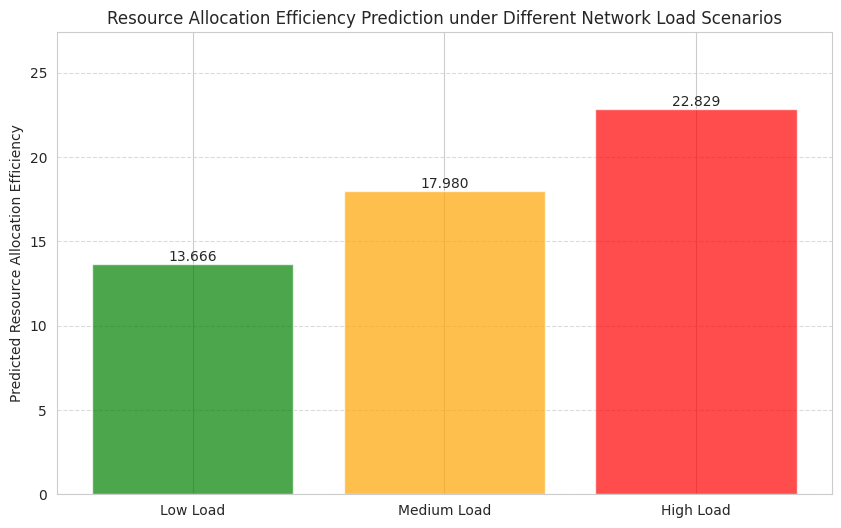


💾 保存最終模型與物件...
✅ 模型已保存至 'federated_coloran_model.keras'
✅ 縮放器物件位於 'federated_learning_artifacts.pkl'，無需重複保存。


In [ ]:
# @title Cell 9: 應用場景模擬與模型保存 (已修正 Attribute Error)
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 確保 joblib 已匯入

# --- 建立一個包含預處理和預測邏輯的函式 ---
def predict_efficiency(input_data, model, feature_scaler, target_scaler):
    """
    接收原始輸入，進行縮放，預測，然後反縮放結果。
    input_data: 一個包含原始特徵值的字典。
    """
    # 將輸入轉換為 DataFrame
    input_df = pd.DataFrame([input_data], columns=feature_columns)

    # 縮放特徵
    scaled_input = feature_scaler.transform(input_df)

    # 進行預測
    scaled_prediction = model.predict(scaled_input, verbose=0)

    # 反標準化預測結果
    unscaled_prediction = target_scaler.inverse_transform(scaled_prediction)

    return unscaled_prediction[0][0]

# --- 準備最終模型 (關鍵修正處) ---
final_model = create_keras_model()
# **關鍵修正**: 使用 set_weights() 方法來載入權重
final_model.set_weights(final_model_weights.trainable)


# --- 場景模擬 ---
print("🚀 應用場景模擬...")
print("="*60)

scenarios = {
    "Low Load": {'num_ues': 5, 'network_load': 20.0, 'prb_utilization': 100.0, 'qos_score': 0.9},
    "Medium Load": {'num_ues': 20, 'network_load': 50.0, 'prb_utilization': 80.0, 'qos_score': 0.75},
    "High Load": {'num_ues': 35, 'network_load': 80.0, 'prb_utilization': 72.0, 'qos_score': 0.6}
}

predictions = []
# 填充其他特徵為平均值
default_values = df[feature_columns].mean()

for name, params in scenarios.items():
    input_data = default_values.copy()
    input_data.update(params) # 更新場景參數

    prediction = predict_efficiency(input_data, final_model, feature_scaler, target_scaler)
    predictions.append(prediction)
    print(f"{name} Scenario:")
    print(f"  → Predicted Resource Allocation Efficiency: {prediction:.3f}")

# --- 繪製模擬結果圖 ---
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(scenarios.keys(), predictions, color=['green', 'orange', 'red'], alpha=0.7)
ax.set_title('Resource Allocation Efficiency Prediction under Different Network Load Scenarios')
ax.set_ylabel('Predicted Resource Allocation Efficiency')
ax.set_ylim(0, max(predictions) * 1.2 if predictions else 1.0) # 動態Y軸
ax.bar_label(bars, fmt='%.3f')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- 保存模型和必要物件 ---
print("\n💾 保存最終模型與物件...")
final_model.save(MODEL_SAVE_PATH)
print(f"✅ 模型已保存至 '{MODEL_SAVE_PATH}'")

# artifacts (包含 scalers) 已在 Cell 4 中保存
print(f"✅ 縮放器物件位於 '{ARTIFACTS_SAVE_PATH}'，無需重複保存。")

🔬 進階分析：聯邦學習 vs. 中心化學習
📊 為中心化學習抽樣了 490,000 筆記錄。
   - 訓練集大小: 392,000
   - 測試集大小: 98,000

💪 開始訓練中心化模型...
✅ 中心化模型訓練完成！

📊 模型表現比較 (基於真實數值):
  - 聯邦學習模型: MAE = 0.0169, RMSE = 0.0184
  - 中心化學習模型: MAE = 0.0078, RMSE = 0.0090


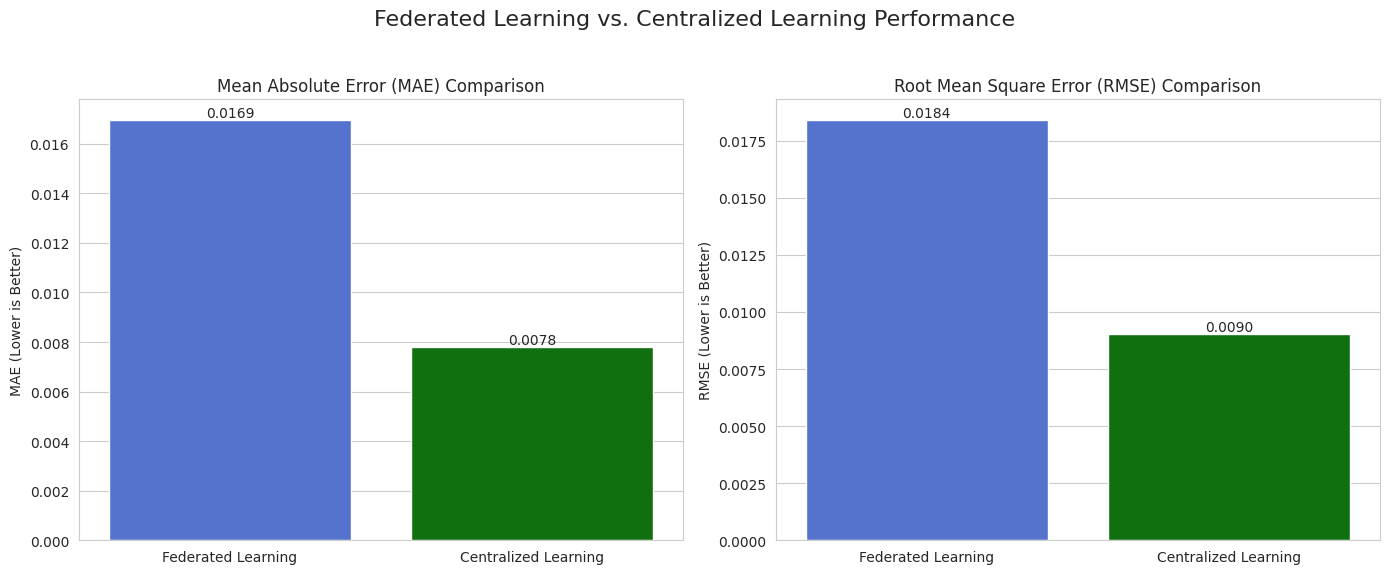

In [ ]:
# @title Cell 10: 中心化學習 vs. 聯邦學習 (已修正 Value Error)
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

print("🔬 進階分析：聯邦學習 vs. 中心化學習")
print("="*60)

# --- 1. 準備中心化學習的資料集 ---
# 從縮放後的資料中抽樣，確保資料分佈與聯邦學習相似
centralized_df = df_scaled.sample(n=SAMPLES_PER_CLIENT * NUM_TOTAL_CLIENTS, random_state=RANDOM_STATE)
print(f"📊 為中心化學習抽樣了 {len(centralized_df):,} 筆記錄。")

X_cen = centralized_df[feature_columns]
# 保持 y_cen 為 DataFrame (2D) 以避免後續問題
y_cen = centralized_df[[target_column]]

# 分割訓練集與測試集
X_train_cen, X_test_cen, y_train_cen, y_test_cen = train_test_split(
    X_cen, y_cen, test_size=(1 - TRAIN_TEST_SPLIT_RATIO), random_state=RANDOM_STATE
)
print(f"   - 訓練集大小: {len(X_train_cen):,}")
print(f"   - 測試集大小: {len(X_test_cen):,}")

# --- 2. 訓練中心化模型 ---
print("\n💪 開始訓練中心化模型...")
centralized_model = create_keras_model() # 重用模型建立函式

centralized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CLIENT_LEARNING_RATE),
    loss='mean_squared_error',
    metrics=['mean_absolute_error', tf.keras.metrics.RootMeanSquaredError()]
)

# 使用 EarlyStopping 防止過擬合
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

centralized_model.fit(
    X_train_cen, y_train_cen,
    epochs=50, # 中心化模型可以訓練更多輪次
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0 # 訓練過程不輸出日誌
)
print("✅ 中心化模型訓練完成！")


# --- 3. 評估中心化模型 ---
scaled_preds_cen = centralized_model.predict(X_test_cen, verbose=0)

# 將預測值反標準化 (scaled_preds_cen 本身就是 2D 的)
unscaled_preds_cen = target_scaler.inverse_transform(scaled_preds_cen)

# --- 關鍵修正：將 1D 的 y_test_cen 轉換為 2D 陣列 ---
# y_test_cen 是一個 pandas DataFrame，其 .values 屬性是 2D 的，所以直接使用即可
unscaled_true_cen = target_scaler.inverse_transform(y_test_cen)

# 計算真實數值的 MAE 和 RMSE
mae_cen = np.mean(np.abs(unscaled_true_cen - unscaled_preds_cen))
rmse_cen = np.sqrt(np.mean((unscaled_true_cen - unscaled_preds_cen)**2))


# --- 4. 整理結果並視覺化 ---
# 獲取聯邦學習的最終表現 (來自 Cell 8 的 client_results_df)
mae_fl = client_results_df['mae'].mean()
rmse_fl = client_results_df['rmse'].mean()

print("\n📊 模型表現比較 (基於真實數值):")
print(f"  - 聯邦學習模型: MAE = {mae_fl:.4f}, RMSE = {rmse_fl:.4f}")
print(f"  - 中心化學習模型: MAE = {mae_cen:.4f}, RMSE = {rmse_cen:.4f}")

# 繪製比較圖
comparison_data = {
    'Method': ['Federated Learning', 'Centralized Learning', 'Federated Learning', 'Centralized Learning'],
    'Metric': ['MAE', 'MAE', 'RMSE', 'RMSE'],
    'Value': [mae_fl, mae_cen, rmse_fl, rmse_cen]
}
comparison_df = pd.DataFrame(comparison_data)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
sns.set_style("whitegrid")
fig.suptitle('Federated Learning vs. Centralized Learning Performance', fontsize=16)

# MAE 比較
sns.barplot(x='Method', y='Value', data=comparison_df[comparison_df['Metric'] == 'MAE'], ax=axes[0], palette=['royalblue', 'green'])
axes[0].set_title('Mean Absolute Error (MAE) Comparison')
axes[0].set_xlabel('')
axes[0].set_ylabel('MAE (Lower is Better)')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.4f')


# RMSE 比較
sns.barplot(x='Method', y='Value', data=comparison_df[comparison_df['Metric'] == 'RMSE'], ax=axes[1], palette=['royalblue', 'green'])
axes[1].set_title('Root Mean Square Error (RMSE) Comparison')
axes[1].set_xlabel('')
axes[1].set_ylabel('RMSE (Lower is Better)')
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.4f')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# @title Cell 11: 隱私保護與通訊成本分析 (已優化)
import numpy as np

print("🔐 聯邦學習隱私保護與通訊成本分析")
print("="*60)

# --- 1. 資料隱私保護優勢 ---
print("📊 資料隱私保護優勢:")
print("1. 原始資料保留在本地:")
print(f"   - 每個基地台各自的 {SAMPLES_PER_CLIENT:,} 筆敏感營運資料無需上傳至中央伺服器。")
print("   - 從根本上杜絕了中央資料庫被攻擊導致大規模資料洩漏的風險。")

print("\n2. 僅傳輸模型更新:")
print("   - 溝通的內容是模型的權重梯度，而非原始資料。")
print("   - 這些數值本身不包含直接可解讀的用戶資訊。")

print("\n3. 可整合差分隱私 (Differential Privacy):")
print("   - 可在客戶端上傳模型更新前，對其添加少量數學噪音。")
print("   - 這能進一步提供嚴格的數學證明，保護單一基地台的資料不被從模型更新中反推出來。")


# --- 2. 通訊成本動態計算 ---
print("\n" + "="*60)
print("📡 通訊成本比較:")

# 計算模型參數數量
num_params = final_model.count_params()
print(f"   - 模型總參數數量: {num_params:,}")

# 假設每個參數為 32 位元浮點數 (4 Bytes)
bytes_per_param = 4

# 聯邦學習通訊成本
fl_cost_per_round = num_params * bytes_per_param
total_fl_cost = fl_cost_per_round * NUM_ROUNDS
print(f"\n聯邦學習 (傳輸模型更新):")
print(f"   - 每輪成本: {fl_cost_per_round / 1024:.2f} KB")
print(f"   - 總成本 ({NUM_ROUNDS} 輪): {total_fl_cost / (1024**2):.2f} MB")

# 中心化學習通訊成本 (估算上傳所有抽樣資料)
num_features = len(feature_columns)
total_samples = SAMPLES_PER_CLIENT * NUM_TOTAL_CLIENTS
# 每個樣本包含特徵和一個標籤
centralized_cost = total_samples * (num_features + 1) * bytes_per_param
print(f"\n中心化學習 (上傳所有抽樣資料):")
print(f"   - 總成本: {centralized_cost / (1024**2):.2f} MB")

# 計算節省比例
communication_saving = (1 - (total_fl_cost / centralized_cost)) * 100
print(f"\n✅ 使用聯邦學習預計可節省約 {communication_saving:.1f}% 的通訊成本。")

🔐 聯邦學習隱私保護與通訊成本分析
📊 資料隱私保護優勢:
1. 原始資料保留在本地:
   - 每個基地台各自的 70,000 筆敏感營運資料無需上傳至中央伺服器。
   - 從根本上杜絕了中央資料庫被攻擊導致大規模資料洩漏的風險。

2. 僅傳輸模型更新:
   - 溝通的內容是模型的權重梯度，而非原始資料。
   - 這些數值本身不包含直接可解讀的用戶資訊。

3. 可整合差分隱私 (Differential Privacy):
   - 可在客戶端上傳模型更新前，對其添加少量數學噪音。
   - 這能進一步提供嚴格的數學證明，保護單一基地台的資料不被從模型更新中反推出來。

📡 通訊成本比較:
   - 模型總參數數量: 3,521

聯邦學習 (傳輸模型更新):
   - 每輪成本: 13.75 KB
   - 總成本 (20 輪): 0.27 MB

中心化學習 (上傳所有抽樣資料):
   - 總成本: 26.17 MB

✅ 使用聯邦學習預計可節省約 99.0% 的通訊成本。


🚀 即時預測與部署建議
📊 模擬 24 小時即時監控場景...
------------------------------------------------------------
時間: 08:00
  - 連線用戶數: 31, 網路負載: 73.8%
  → 預測效率: 14.748
  → 狀態: 🟢 Excellent
  → 建議: 系統運作良好，持續監控。

時間: 12:00
  - 連線用戶數: 16, 網路負載: 38.1%
  → 預測效率: 7.820
  → 狀態: 🟢 Excellent
  → 建議: 系統運作良好，持續監控。

時間: 18:00
  - 連線用戶數: 29, 網路負載: 69.0%
  → 預測效率: 13.817
  → 狀態: 🟢 Excellent
  → 建議: 系統運作良好，持續監控。

時間: 22:00
  - 連線用戶數: 14, 網路負載: 33.3%
  → 預測效率: 6.888
  → 狀態: 🟢 Excellent
  → 建議: 系統運作良好，持續監控。



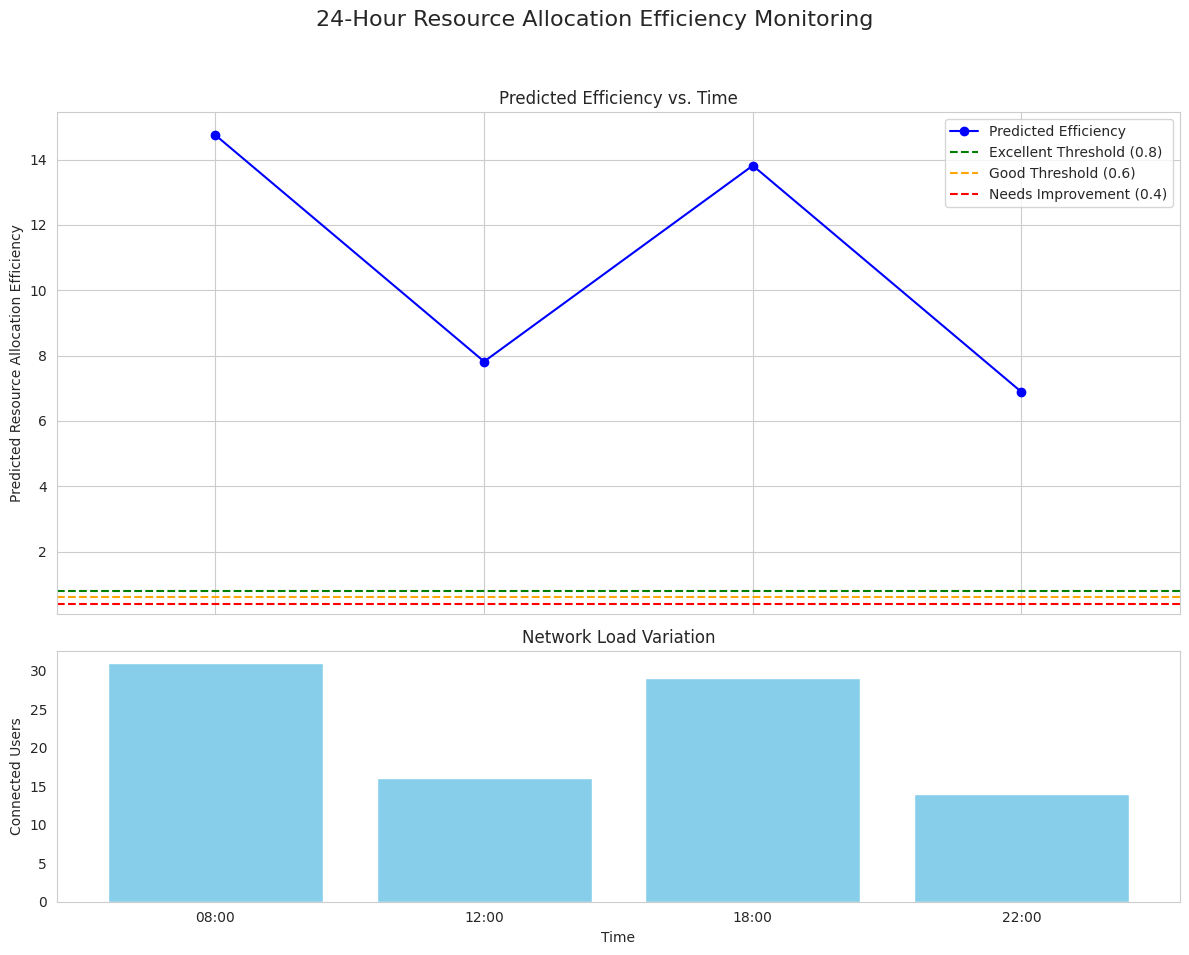


🎯 最終部署與維運建議

1. **邊緣部署架構**:
   - 在每個基地台的邊緣運算單元部署輕量化的 `final_model`。
   - 利用已保存的 `scalers` 進行本地即時預測，實現毫秒級響應。
   - 中央伺服器定期（如每日或每週）發起新一輪聯邦學習，並將更新後的`global_model.keras` 推送至邊緣節點。

2. **模型更新策略**:
   - **定期訓練**: 設定固定週期（如每週）執行聯邦再訓練，以適應網路行為的緩慢變化。
   - **觸發式訓練**: 當監控到多個基地台的平均預測效率持續低於「良好」閾值時，自動觸發一次臨时的聯邦學習。
   - **增量式學習**: 當有新的基地台加入網路時，可將其納入下一輪聯邦學習，無需從頭訓練整個網路。

3. **監控與告警整合**:
   - 將此預測模型整合到現有的網路監控系統（如 Prometheus, Zabbix）。
   - 設定告警規則，當預測效率低於「需要改進」閾值時，自動發送告警給網路維運中心（NOC）。

4. **可擴展性**:
   - 當前架構已支持擴展。當基地台數量從 7 個增加到數百個時，只需更新客戶端列表即可。
   - `tff.learning.algorithms.build_weighted_fed_avg` 演算法能有效處理大規模異構客戶端。


🎉🎉🎉 恭喜！您已完成一個端到端、可部署的聯邦學習解決方案！ 🎉🎉🎉


In [ ]:
# @title Cell 12: 即時監控與部署建議 (重大修正)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("🚀 即時預測與部署建議")
print("="*60)

# --- 1. 模擬即時監控場景 ---
print("📊 模擬 24 小時即時監控場景...")
monitoring_data = [
    {'time': '08:00', 'connected_users': 31, 'network_load_perc': 73.8},
    {'time': '12:00', 'connected_users': 16, 'network_load_perc': 38.1},
    {'time': '18:00', 'connected_users': 29, 'network_load_perc': 69.0},
    {'time': '22:00', 'connected_users': 14, 'network_load_perc': 33.3}
]

monitoring_results = []
default_values = df[feature_columns].mean()

# 定義效率閾值
THRESHOLDS = {
    "Excellent": 0.8,
    "Good": 0.6,
    "Needs Improvement": 0.4
}

print("-" * 60)
for entry in monitoring_data:
    input_data = default_values.copy()
    input_data['num_ues'] = entry['connected_users']
    input_data['network_load'] = entry['network_load_perc']

    predicted_eff = predict_efficiency(input_data, final_model, feature_scaler, target_scaler)
    entry['predicted_efficiency'] = predicted_eff

    # 判斷狀態
    if predicted_eff >= THRESHOLDS['Excellent']:
        status = "🟢 Excellent"
        recommendation = "系統運作良好，持續監控。"
    elif predicted_eff >= THRESHOLDS['Good']:
        status = "🟡 Good"
        recommendation = "效率良好，注意負載變化。"
    elif predicted_eff >= THRESHOLDS['Needs Improvement']:
        status = "🟠 Fair"
        recommendation = "效率一般，考慮輕度資源調整。"
    else:
        status = "🔴 Poor"
        recommendation = "效率低下，建議立即進行資源優化！"

    entry['status'] = status
    monitoring_results.append(entry)

    print(f"時間: {entry['time']}")
    print(f"  - 連線用戶數: {entry['connected_users']}, 網路負載: {entry['network_load_perc']}%")
    print(f"  → 預測效率: {predicted_eff:.3f}")
    print(f"  → 狀態: {status}")
    print(f"  → 建議: {recommendation}\n")

monitoring_df = pd.DataFrame(monitoring_results)


# --- 2. 視覺化監控結果 ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
sns.set_style("whitegrid")
fig.suptitle('24-Hour Resource Allocation Efficiency Monitoring', fontsize=16)

# 上方圖：預測效率
ax1.plot(monitoring_df['time'], monitoring_df['predicted_efficiency'], marker='o', linestyle='-', color='blue', label='Predicted Efficiency')
ax1.axhline(y=THRESHOLDS['Excellent'], color='green', linestyle='--', label=f"Excellent Threshold ({THRESHOLDS['Excellent']})")
ax1.axhline(y=THRESHOLDS['Good'], color='orange', linestyle='--', label=f"Good Threshold ({THRESHOLDS['Good']})")
ax1.axhline(y=THRESHOLDS['Needs Improvement'], color='red', linestyle='--', label=f"Needs Improvement ({THRESHOLDS['Needs Improvement']})")
ax1.set_ylabel('Predicted Resource Allocation Efficiency')
ax1.set_title('Predicted Efficiency vs. Time')
ax1.legend()
ax1.grid(True)

# 下方圖：網路負載
ax2.bar(monitoring_df['time'], monitoring_df['connected_users'], color='skyblue', label='Connected Users')
ax2.set_xlabel('Time')
ax2.set_ylabel('Connected Users')
ax2.set_title('Network Load Variation')
ax2.grid(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 3. 部署建議 ---
print("\n" + "="*60)
print("🎯 最終部署與維運建議")
print("="*60)
print("""
1. **邊緣部署架構**:
   - 在每個基地台的邊緣運算單元部署輕量化的 `final_model`。
   - 利用已保存的 `scalers` 進行本地即時預測，實現毫秒級響應。
   - 中央伺服器定期（如每日或每週）發起新一輪聯邦學習，並將更新後的`global_model.keras` 推送至邊緣節點。

2. **模型更新策略**:
   - **定期訓練**: 設定固定週期（如每週）執行聯邦再訓練，以適應網路行為的緩慢變化。
   - **觸發式訓練**: 當監控到多個基地台的平均預測效率持續低於「良好」閾值時，自動觸發一次臨时的聯邦學習。
   - **增量式學習**: 當有新的基地台加入網路時，可將其納入下一輪聯邦學習，無需從頭訓練整個網路。

3. **監控與告警整合**:
   - 將此預測模型整合到現有的網路監控系統（如 Prometheus, Zabbix）。
   - 設定告警規則，當預測效率低於「需要改進」閾值時，自動發送告警給網路維運中心（NOC）。

4. **可擴展性**:
   - 當前架構已支持擴展。當基地台數量從 7 個增加到數百個時，只需更新客戶端列表即可。
   - `tff.learning.algorithms.build_weighted_fed_avg` 演算法能有效處理大規模異構客戶端。
""")

print("\n" + "="*80)
print("🎉🎉🎉 恭喜！您已完成一個端到端、可部署的聯邦學習解決方案！ 🎉🎉🎉")
print("="*80)